## Plotting the distributon of HERV elements, human genes, and TF binding sites in the MHC

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from collections import OrderedDict
from utils.enrichment import HERVEnrichment

In this notebook we'll generate a plot of the genomic locations of human genes, LTRs, and transcription factor binding sites in the MHC. First we'll start up an instance of the `HERVEnrichment` class and load in the MHC region.

In [2]:
# load in the MHC region
enrichment = HERVEnrichment()
mhc_start = min(enrichment.human_annotations.loc[(enrichment.human_annotations['name'] == 'MOG') & 
                                                 (enrichment.human_annotations['Chr'].str.contains('chr6$', regex = True)), 'Start'])
mhc_end = max(enrichment.human_annotations.loc[(enrichment.human_annotations['name'] == 'COL11A2') & 
                                               (enrichment.human_annotations['Chr'].str.contains('chr6$', regex = True)), 'End'])
enrichment.loadRegion(mhc_start, mhc_end, chrom = 6)

Next we'll extract binding sites for EZH2 and DUX4 transcription factors and simplify some of the HERV/human gene features so we can plot them.

In [3]:
# get EZH2 and DUX4 TFBS in the MHC, isolate top cell line
EZH2_mhc = enrichment.TFBS_in_region[enrichment.TFBS_in_region['TF'] == 'EZH2']
EZH2_mhc = EZH2_mhc[EZH2_mhc['Cell line'] == EZH2_mhc['Cell line'].value_counts().index[0]]
DUX4_mhc = enrichment.TFBS_in_region[enrichment.TFBS_in_region['TF'] == 'DUX4']
DUX4_mhc = DUX4_mhc[DUX4_mhc['Cell line'] == DUX4_mhc['Cell line'].value_counts().index[0]]

# simplify LTR families in the MHC
mhc_LTRs = enrichment.LTRs_in_region
mhc_LTRs['family'] = np.where(mhc_LTRs['family'].isin(['ERVL-MaLR', 'ERV1', 'ERVL', 'ERVK']), 
                              mhc_LTRs['family'], 
                              'other')

# get genes in MHC
mhc_genes = enrichment.genes_in_region
mhc_genes['gene_type'] = mhc_genes['gene_type'].str.replace('_', ' ')
mhc_genes['gene_type'] = np.where(mhc_genes['gene_type'].isin(['protein coding', 'pseudogene', 'lncRNA']),
                                  mhc_genes['gene_type'], 
                                  'other')

Then we'll make the plot, with four tracks spanning the length of the MHC: 1) human genes, 2) HERVs, 3) EZH2 binding sites in HeLa-S3 cells, and 4) DUX4 binding sites in 22Rv1 cells.

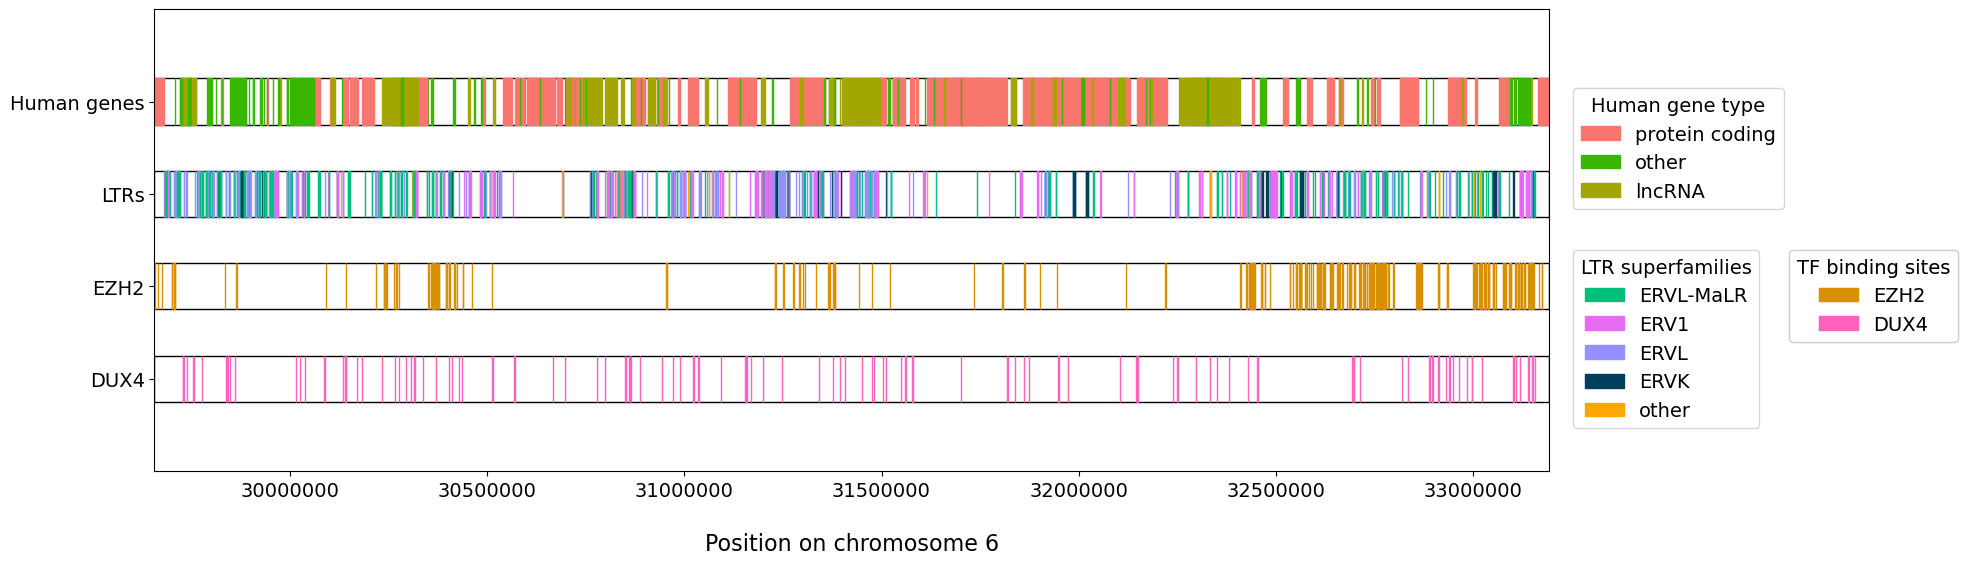

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (18, 6))
plt.ticklabel_format(style = 'plain')
plt.xlim(mhc_start, mhc_end)
plt.ylim(0, 1000)

# add first view - HERV elements in the MHC
rect = Rectangle((mhc_start, 750), width = mhc_end - mhc_start, height = 100, facecolor = 'white', edgecolor = 'black')
ax.add_patch(rect)
type_colors = {'protein coding': '#F8766D', 'pseudogene': '#00BFC4', 'lncRNA': '#A3A500', 'other': '#39B600'}
type_added_to_legend = {'protein coding': False, 'pseudogene': False, 'lncRNA': False, 'other': False}
for i, row in mhc_genes.iterrows():
    if not type_added_to_legend[row['gene_type']]:
        lab = row['gene_type']
        type_added_to_legend[row['gene_type']] = True
    else: 
        lab = ''
    rect = Rectangle((row['Start'], 750), width = row['End'] - row['Start'], height = 100, 
                     color = type_colors[row['gene_type']], label = lab)
    ax.add_patch(rect)
    
# add legend for human genes
human_gene_legend = plt.legend(fontsize = 14, bbox_to_anchor = [1.01, 0.85], title = 'Human gene type')
human_gene_legend.get_title().set_fontsize('14') 
plt.gca().add_artist(human_gene_legend)
    

# add second view - HERV elements in the MHC
rect = Rectangle((mhc_start, 550), width = mhc_end - mhc_start, height = 100, facecolor = 'white', edgecolor = 'black')
ax.add_patch(rect)
family_colors = {'ERVL-MaLR': '#00BF7D', 'ERV1': '#E76BF3', 'ERVL': '#9590FF', 'ERVK': '#003F5C', 'other': '#FFA600'}
family_added_to_legend = OrderedDict({fam: False for fam in pd.unique(mhc_LTRs['family'])})
LTR_legend_elements = []
for i, row in mhc_LTRs.iterrows():
    if not family_added_to_legend[row['family']]:
        lab = row['family']
        family_added_to_legend[row['family']] = True
        rect = Rectangle((row['Start'], 550), width = row['End'] - row['Start'], height = 100, 
                     color = family_colors[row['family']], label = lab)
        LTR_legend_elements.append(rect)
    else: 
        lab = ''
        rect = Rectangle((row['Start'], 550), width = row['End'] - row['Start'], height = 100, 
                         color = family_colors[row['family']], label = lab)
    ax.add_patch(rect)
    
LTR_family_legend = plt.legend(LTR_legend_elements, family_added_to_legend.keys(), 
                                fontsize = 14, bbox_to_anchor = [1.01, 0.5], title = 'LTR superfamilies')
LTR_family_legend.get_title().set_fontsize('14') 
plt.gca().add_artist(LTR_family_legend)

# add third view of the genome - EZH2 and DUX4 binding sites in the MHC
TF_colors = {'EZH2': '#D89000', 'DUX4': '#FF62BC'}
TF_added_to_legend = {'EZH2': False, 'DUX4': False}    
rect = Rectangle((mhc_start, 350), width = mhc_end - mhc_start, height = 100, facecolor = 'white', edgecolor = 'black')
ax.add_patch(rect)
TFBS_legend_elements = []
for i, row in EZH2_mhc.iterrows():
    if not TF_added_to_legend[row['TF']]:
        lab = row['TF']
        TF_added_to_legend[row['TF']] = True
        rect = Rectangle((row['Start'], 350), width = row['End'] - row['Start'], height = 100, 
                     color = TF_colors[row['TF']], label = lab)
        TFBS_legend_elements.append(rect)
    else: 
        lab = ''
        rect = Rectangle((row['Start'], 350), width = row['End'] - row['Start'], height = 100, 
                         color = TF_colors[row['TF']], label = lab)
    ax.add_patch(rect)
    
rect = Rectangle((mhc_start, 150), width = mhc_end - mhc_start, height = 100, facecolor = 'white', edgecolor = 'black')
ax.add_patch(rect)
for i, row in DUX4_mhc.iterrows():
    if not TF_added_to_legend[row['TF']]:
        lab = row['TF']
        TF_added_to_legend[row['TF']] = True
        rect = Rectangle((row['Start'], 150), width = row['End'] - row['Start'], height = 100, 
                     color = TF_colors[row['TF']], label = lab)
        TFBS_legend_elements.append(rect)
    else: 
        lab = ''
        rect = Rectangle((row['Start'], 150), width = row['End'] - row['Start'], height = 100, 
                     color = TF_colors[row['TF']], label = lab)
    ax.add_patch(rect)

TFBS_legend = plt.legend(TFBS_legend_elements, ['EZH2', 'DUX4'], 
                         title = 'TF binding sites', fontsize = 14, bbox_to_anchor = [1.30, 0.5])
TFBS_legend.get_title().set_fontsize('14') 
plt.gca().add_artist(TFBS_legend)
    
ax.tick_params(axis='x', which='major', labelsize=14)
plt.yticks([200, 400, 600, 800], ['DUX4', 'EZH2', 'LTRs', 'Human genes'], fontsize = 14)
plt.xlabel('\nPosition on chromosome 6', fontsize = 16)
plt.savefig('figures/fig1a.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight')

plt.show()